<a href="https://colab.research.google.com/github/Tsunami-Song/DSDNE/blob/main/experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
from __future__ import print_function, division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py 
import plotly.graph_objs as go 
py.init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(15)
edges = pd.read_csv("/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features
features = pd.merge(features,classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: '0' if x == "unknown" else x)

In [2]:
data = pd.read_csv(r"/content/drive/MyDrive/SDNE/sdne_feature2_pro_b8.txt")

orig2contiguos = pd.read_csv(r"/content/drive/MyDrive/AML/EvolveGCN-master/elliptic_bitcoin_dataset/elliptic_txs_orig2contiguos.csv")
orig2contiguos.columns=["originalId","txId"]
sdne_feature = pd.merge(orig2contiguos,data,on='txId')
sdne_feature = sdne_feature.drop('txId',axis=1)
sdne_feature_col = ["sdne_feature_"+str(i) for i in range(1,65)]
sdne_feature.columns=["txId"]+sdne_feature_col
sdne_feature_names = ["sdne_feature_"+str(i) for i in range(1,65)]


In [3]:

data_pro = pd.read_csv(r"/content/drive/MyDrive/SDNE/sdne_feature_stack2_pro2.txt")
orig2contiguos = pd.read_csv(r"/content/drive/MyDrive/AML/EvolveGCN-master/elliptic_bitcoin_dataset/elliptic_txs_orig2contiguos.csv")
orig2contiguos.columns=["originalId","txId"]
dsdne_feature = pd.merge(orig2contiguos,data_pro,on='txId')
dsdne_feature = dsdne_feature.drop('txId',axis=1)
sdne_feature_col = ["sdne_feature_"+str(i) for i in range(1,65)]
dsdne_feature.columns=["txId"]+sdne_feature_col
sdne_feature_names = ["sdne_feature_"+str(i) for i in range(1,65)]

In [4]:
y_train = features[((features['class']=='1') & (features['time_step']<35)) | ((features['class']=='2') & (features['time_step']<35))]["class"]
y_train = y_train.apply(lambda x: 0 if x == '2' else 1 )
X_data = features[((features['class']=='1') & (features['time_step']<35)) | ((features['class']=='2') & (features['time_step']<35))]
X_train_ori = X_data[tx_features+agg_features]
X_data_sdne = pd.merge(X_data,sdne_feature,how='inner')
X_train_sdne = X_data_sdne[tx_features+agg_features+sdne_feature_names]
X_data_dsdne = pd.merge(X_data,dsdne_feature,how='inner')
X_train_dsdne = X_data_dsdne[tx_features+agg_features+sdne_feature_names]

In [5]:

def work_illicit_F1(sdne_flag):
  #print("Start!")
  illicit_f1 = list()
  illicit_nums =list()
  for timestep in range(35,50):
    illicit_num = features[((features['class']=='1') & (features['time_step']==timestep))].shape[0]
    if(sdne_flag==1):
      data = features[((features['class']=='1') & (features['time_step']==timestep)) | ((features['class']=='2') & (features['time_step']==timestep))]
      X_test = pd.merge(data,sdne_feature,how='inner')[tx_features+agg_features+sdne_feature_names]
      y_test = features[((features['class']=='1') & (features['time_step']==timestep)) | ((features['class']=='2') & (features['time_step']==timestep))]['class']

      preds = clf_sdne.predict(X_test)
    elif(sdne_flag==2):
      data = features[((features['class']=='1') & (features['time_step']==timestep)) | ((features['class']=='2') & (features['time_step']==timestep))]
      X_test = pd.merge(data,dsdne_feature,how='inner')[tx_features+agg_features+sdne_feature_names]
      y_test = features[((features['class']=='1') & (features['time_step']==timestep)) | ((features['class']=='2') & (features['time_step']==timestep))]['class']
      
      preds = clf_dsdne.predict(X_test)
    elif(sdne_flag==0):
      X_test = features[((features['class']=='1') & (features['time_step']==timestep)) | ((features['class']=='2') & (features['time_step']==timestep))][tx_features+agg_features]
      y_test = features[((features['class']=='1') & (features['time_step']==timestep)) | ((features['class']=='2') & (features['time_step']==timestep))]['class']
      preds = clf_ori.predict(X_test)
    y = y_test.apply(lambda x: 0 if x == '2' else 1 )
    #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=0,shuffle=True)
    
    #class_weight="balanced"{0:1,1:20}
    
    prec,rec,f1,num = precision_recall_fscore_support(y,preds, average=None,zero_division=0)
    illicit_f1.append(f1[1])
    illicit_nums.append(illicit_num)
    micro_f1 = f1_score(y,preds,average='micro')
  return illicit_f1,sum(illicit_f1)

  

AF illicit F1 in total 7.765457987564187
AF+SDNE illicit F1 in total 7.765457987564187
AF+DSDNE illicit F1 in total 7.765457987564187
Compare illicit F1


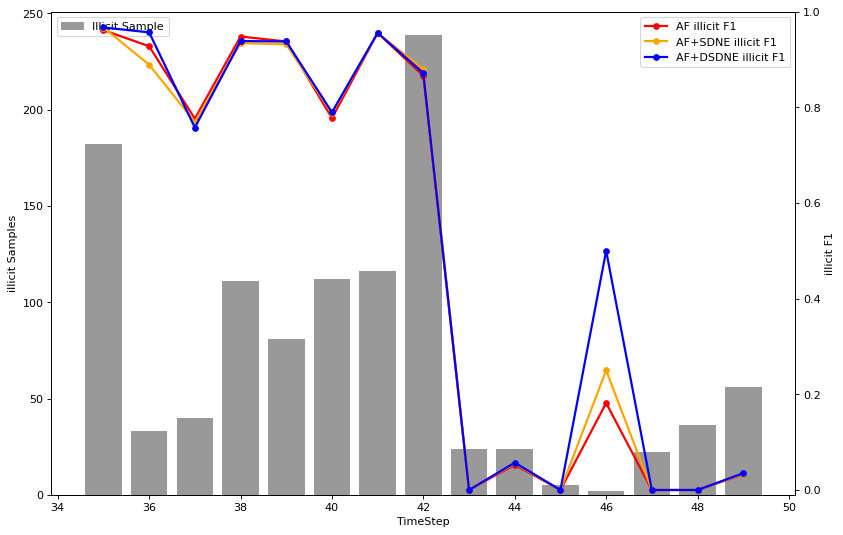

In [6]:
rf_random_state = 0
clf_ori = RandomForestClassifier(n_estimators=50,max_features=50,  max_depth=100,random_state=rf_random_state).fit(X_train_ori,y_train)
clf_sdne = RandomForestClassifier(n_estimators=50,max_features=50, max_depth=100,random_state=rf_random_state).fit(X_train_sdne,y_train)
clf_dsdne = RandomForestClassifier(n_estimators=50,max_features=50, max_depth=100,random_state=rf_random_state).fit(X_train_dsdne,y_train)
ff0,sum0 = work_illicit_F1(0)
ff1,sum1 = work_illicit_F1(1)
ff2,sum2 = work_illicit_F1(2)
print("AF illicit F1 in total",sum2)
print("AF+SDNE illicit F1 in total",sum2)
print("AF+DSDNE illicit F1 in total",sum2)
print("Compare illicit F1")
timestep = np.arange(35,50)
plt.figure(figsize=(12,8), dpi=80)
illicit_nums = [182, 33, 40, 111, 81, 112, 116, 239, 24, 24, 5, 2, 22, 36, 56]
illicit_nums_t = illicit_nums
plt.bar(x=timestep, height=illicit_nums_t, label='Illicit Sample', color='gray', alpha=0.8)
plt.legend(loc="upper left")

plt.xlabel("TimeStep")
plt.ylabel("illicit Samples")
ax2 = plt.twinx()
ax2.set_ylabel("illicit F1")

ax2.set_ylim([-0.01, 1.0])
ax3 = plt.plot(timestep, ff0, "r", marker='.', c='red', ms=10, linewidth='2', label="AF illicit F1")
ax4 = plt.plot(timestep, ff1, "r", marker='.', c='orange', ms=10, linewidth='2', label="AF+SDNE illicit F1")
ax5 = plt.plot(timestep, ff2, "r", marker='.', c='blue', ms=10, linewidth='2', label="AF+DSDNE illicit F1")

plt.legend(labels = ["AF illicit F1","AF+SDNE illicit F1","AF+DSDNE illicit F1"])
plt.savefig("Compare.jpg")
plt.show()